# Corporate Performance Prediction using ESG and Governance Metrics

This project analyzes the relationship between corporate governance factors, ESG(Environmental, Social, Governance) metrics, and financial performance to predict company profitability quartiles.

**Business Problem:** Can we predict a company's financial performance (net income quartile) based on board composition, ESG scores, and other governance metrics?

**Target Variable:** `ni_percentile` - Net income quartile.
**Goal:** Identify which governance and ESG factors are most predictive of financial performance

## 1. Setup & Configuration

In [108]:
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB,GaussianNB, BernoulliNB, ComplementNB
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, 
    recall_score, 
    precision_score, 
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier
)
from sklearn.preprocessing import (
    MinMaxScaler, 
    PolynomialFeatures,
    FunctionTransformer, 
    StandardScaler, 
    OneHotEncoder,
    QuantileTransformer, 
    KBinsDiscretizer
) 


### Data Loading

In [6]:
path='Data.csv'
df = pd.read_csv(path)
df.describe()


,year,rh_num,numberdirectors,genderratio,nationalitymix,attrition,iva_company_rating_num,IVA_rating_trend,industry_adjusted_score,weighted_average_score,environmental_pillar_score,social_pillar_score,governance_pillar_score,sale,ni,roa,salesgrowth,mve,return1yr_comp,ind_num
count,10973.000000,10973.000000,10973.000000,10972.000000,10508.000000,5752.000000,10973.000000,10185.000000,10973.000000,10973.000000,10973.000000,10973.000000,10972.000000,10748.000000,10748.000000,10748.000000,10689.000000,1.092600e+04,10762.000000,10973.000000
mean,2018.037911,4.801968,9.212339,0.807996,0.120527,0.049670,3.552994,0.061463,4.380476,4.537009,4.696273,4.185683,5.317918,7790.904218,541.172157,-0.003588,0.472688,1.312586e+04,0.171177,5.413652
std,1.406142,2.020328,2.478696,0.114619,0.196326,0.059878,1.304820,0.445974,1.969199,0.845068,2.215789,1.527776,1.368263,25448.812459,2332.329163,0.198274,10.527411,4.402814e+04,1.843392,2.682993
min,2016.000000,1.000000,1.000000,0.250000,0.000000,0.000000,1.000000,-3.000000,0.000000,1.400000,0.000000,0.000000,0.000000,-875.710000,-22440.000000,-5.240366,-1.661021,1.500400e+00,-0.971121,1.000000
25%,2017.000000,3.000000,8.000000,0.727000,0.000000,0.000000,3.000000,0.000000,2.900000,4.000000,3.200000,3.200000,4.400000,406.005500,0.146500,0.000240,-0.017643,9.352118e+02,-0.146645,3.000000
50%,2018.000000,5.000000,9.000000,0.800000,0.000000,0.000000,3.000000,0.000000,4.200000,4.500000,4.600000,4.100000,5.400000,1301.306500,76.677000,0.022678,0.057456,2.539384e+03,0.063924,6.000000
75%,2019.000000,7.000000,11.000000,0.889000,0.200000,0.100000,4.000000,0.000000,5.700000,5.100000,6.300000,5.100000,6.300000,4569.744250,326.050000,0.062714,0.159433,7.834373e+03,0.296107,7.000000
max,2020.000000,7.000000,33.000000,1.000000,0.900000,0.400000,7.000000,3.000000,10.000000,8.400000,10.000000,10.000000,9.600000,556933.000000,59531.000000,1.285017,710.679487,1.966079e+06,146.444934,12.000000


## 2. Data Exploration and Understanding

### Dataset Structure

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10973 entries, 0 to 10972
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ticker                      10973 non-null  object 
 1   companyname                 10973 non-null  object 
 2   year                        10973 non-null  int64  
 3   country                     10970 non-null  object 
 4   rh_label                    10973 non-null  object 
 5   rh_num                      10973 non-null  int64  
 6   numberdirectors             10973 non-null  int64  
 7   genderratio                 10972 non-null  float64
 8   nationalitymix              10508 non-null  float64
 9   attrition                   5752 non-null   float64
 10  iva_company_rating          10973 non-null  object 
 11  iva_company_rating_num      10973 non-null  int64  
 12  IVA_rating_trend            10185 non-null  float64
 13  iva_industry                109

### Correlation Analysis

<Axes: >

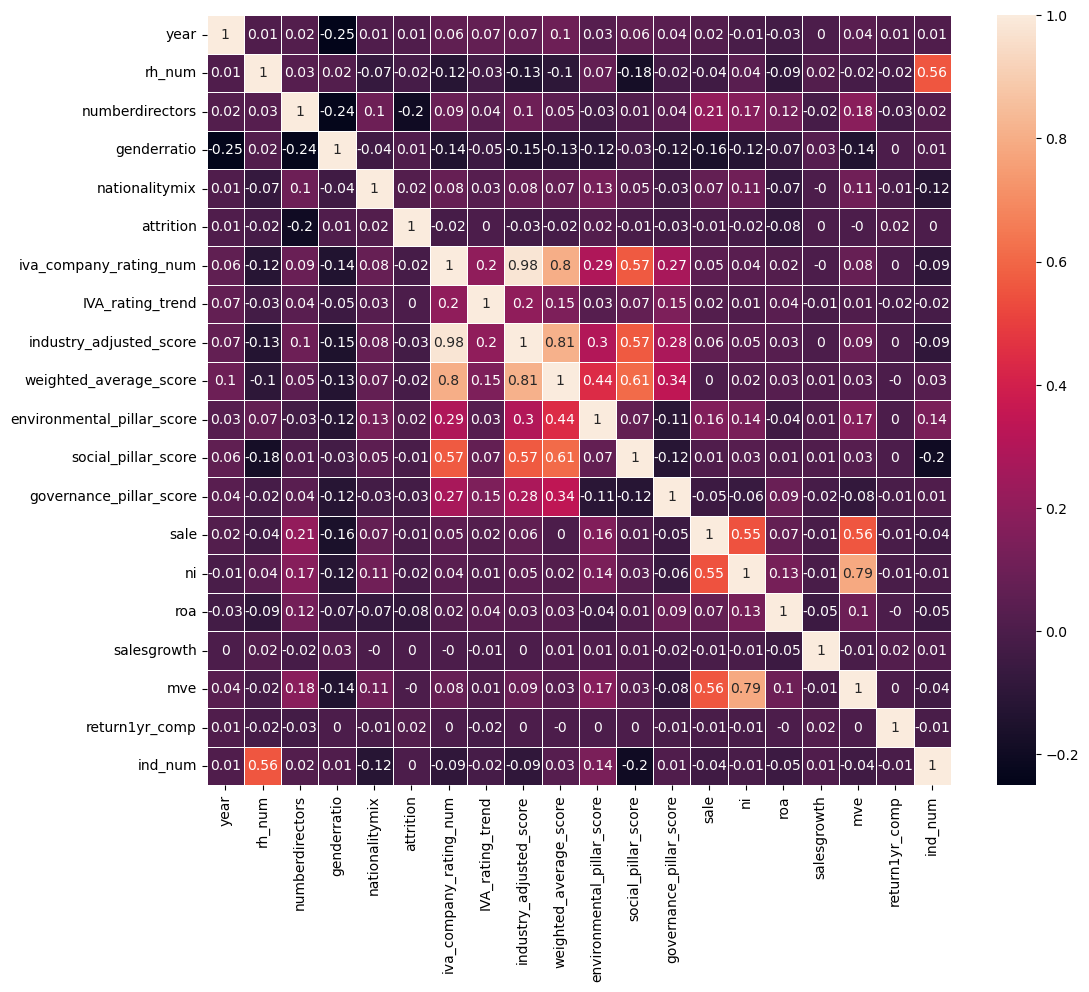

In [64]:
continuous_data = df.select_dtypes(include=['int64','float64']).columns.tolist()
corr_matrix = df[continuous_data].corr().round(2)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot= True,linewidths=.5)
 

**Correlation Observations:**
- ESG pillar scores show moderate to strong positive correlations with each other
- Financial metrics (ni, sale, mve) are highly correlated, indicating companies with high sales tend to have high market values

### Gender Ratio Quartile Analysis
Dividing companies into quartiles based on board gender ratio to analyze how board diversity correlates with:
- ESG scores
- Financial performance
- Company ratings

In [83]:
X = df.copy()
X['genderratio_bin'] = pd.qcut(X['genderratio'], q=4)
X['genderratio_bin'] = X['genderratio_bin'].astype(str)

/var/folders/vp/rh6t6tmd1sl23sgs8jp4g7r80000gn/T/ipykernel_7997/2826777053.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[2].boxplot(gender_ratio_bin_values.values(), labels=gender_ratio_bin_values.keys());


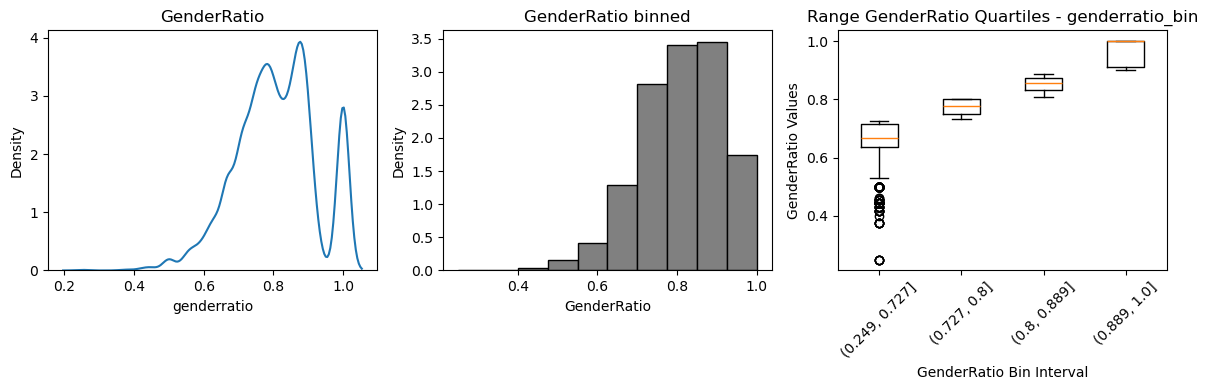

In [87]:
fig, axs = plt.subplots(1,3, figsize=(12,4))

sns.kdeplot(X["genderratio"].dropna(), ax=axs[0])
axs[0].set_title("GenderRatio")

axs[1].hist(X["genderratio"],  density=True, color='grey',  edgecolor='black')
axs[1].set_title("GenderRatio binned")
axs[1].set_xlabel("GenderRatio")
axs[1].set_ylabel("Density")


gender_ratio_bin_values = {
    '(0.249, 0.727]': X[X['genderratio_bin'] == '(0.249, 0.727]']['genderratio'],
    '(0.727, 0.8]': X[X['genderratio_bin'] == '(0.727, 0.8]']['genderratio'] ,
    '(0.8, 0.889]': X[X['genderratio_bin'] == '(0.8, 0.889]']['genderratio'],
    '(0.889, 1.0]': X[X['genderratio_bin'] == '(0.889, 1.0]']['genderratio'],
}
axs[2].boxplot(gender_ratio_bin_values.values(), labels=gender_ratio_bin_values.keys());
axs[2].set_title("Range GenderRatio Quartiles - genderratio_bin")
axs[2].set_xlabel("GenderRatio Bin Interval")
axs[2].set_ylabel("GenderRatio Values")
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [12]:
grouped_by_bin_genderratio = X.groupby("genderratio_bin").agg(
    {
        "numberdirectors": 'mean',
        "attrition": 'mean',
        "iva_company_rating_num": 'mean',
        "IVA_rating_trend":'mean',
        "salesgrowth":'mean',
        "return1yr_comp":'mean',
        "ni":'mean',
        "roa":'mean',
        "social_pillar_score":'mean',
        "environmental_pillar_score":'mean',
        "weighted_average_score":'mean',
    }) 
grouped_by_bin_genderratio 

/var/folders/vp/rh6t6tmd1sl23sgs8jp4g7r80000gn/T/ipykernel_7997/2874883041.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_bin_genderratio = X.groupby("genderratio_bin").agg(


,numberdirectors,attrition,iva_company_rating_num,IVA_rating_trend,salesgrowth,return1yr_comp,ni,roa,social_pillar_score,environmental_pillar_score,weighted_average_score
genderratio_bin,,,,,,,,,,,
"(0.249, 0.727]",9.747391,0.051356,3.801367,0.080816,0.147602,0.190893,1015.014722,0.012508,4.253724,5.166211,4.684383
"(0.727, 0.8]",9.544034,0.045308,3.675071,0.085949,0.223177,0.163557,573.112034,0.005342,4.225888,4.746839,4.611328
"(0.8, 0.889]",8.920538,0.047152,3.383863,0.047826,0.897306,0.143966,291.683516,-0.013817,4.111522,4.545355,4.455532
"(0.889, 1.0]",8.519715,0.057497,3.325416,0.021390,0.577658,0.197905,258.010868,-0.020985,4.158100,4.243468,4.370071


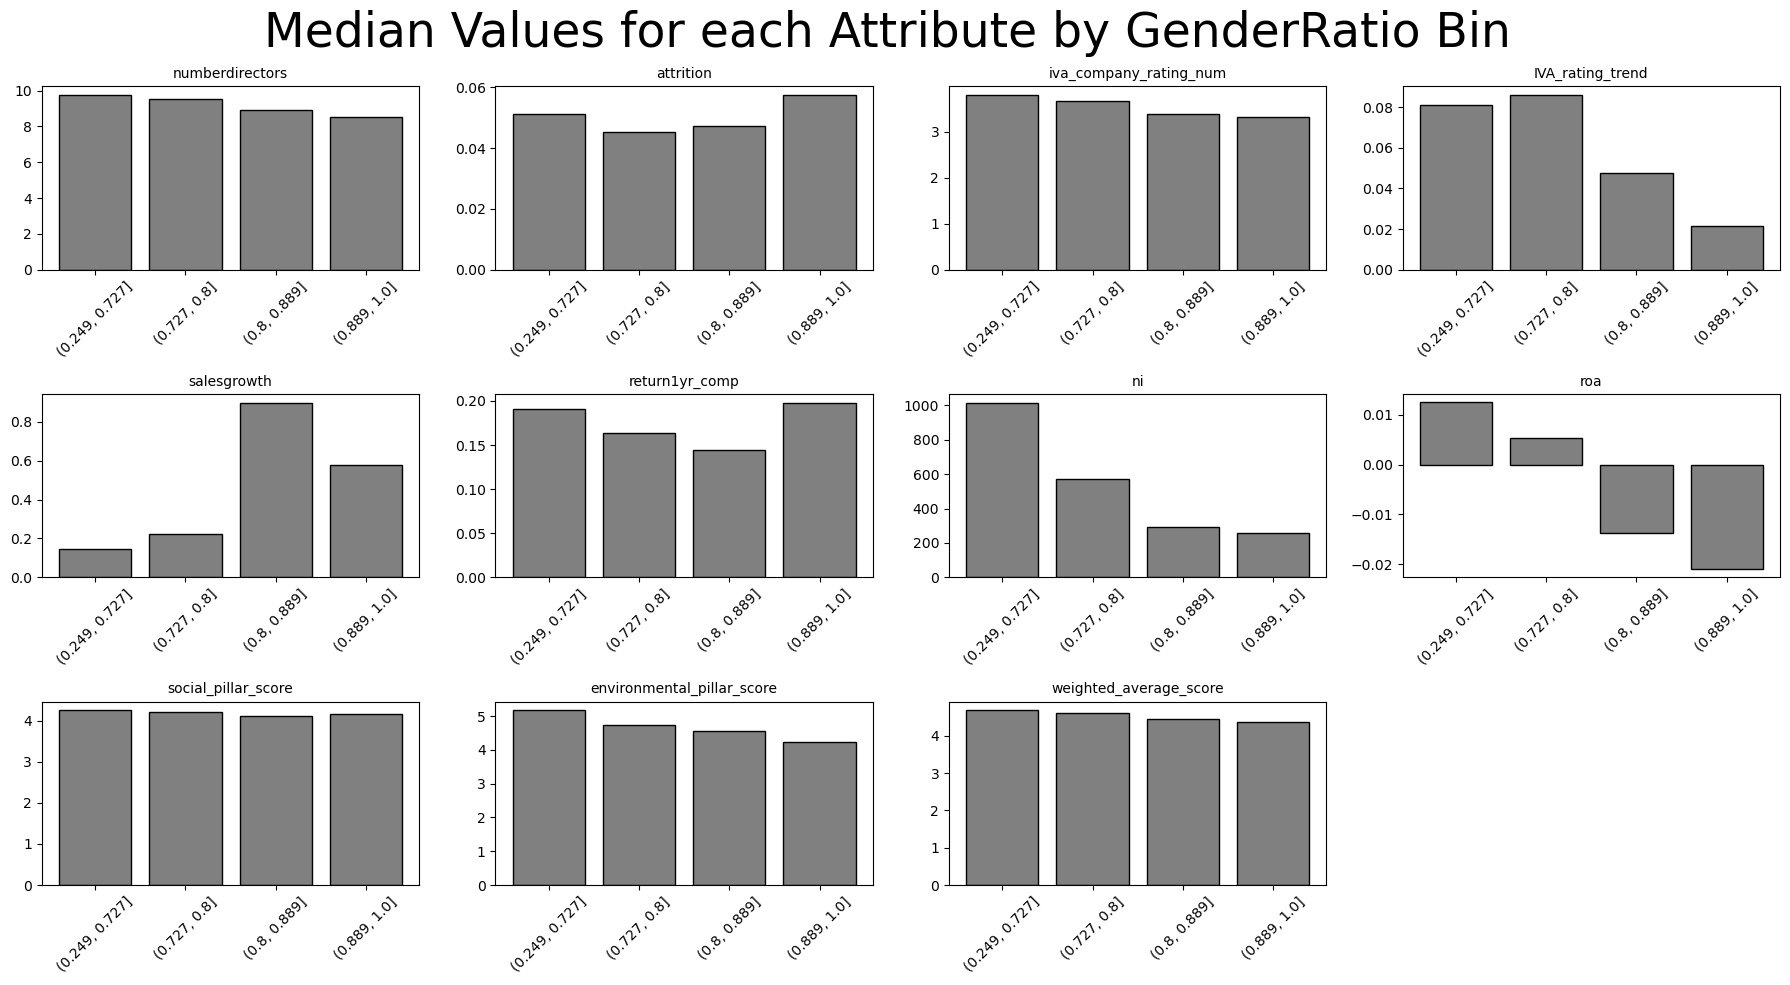

In [93]:

fig, axs = plt.subplots(3, 4, figsize=(18, 10)) 
axs= axs.flatten()
x_labels = grouped_by_bin_genderratio.index.astype(str)
for i, col in enumerate(grouped_by_bin_genderratio.columns):
    ax = axs[i]
    
    ax.bar(x_labels,grouped_by_bin_genderratio[col], color='grey', edgecolor='black')
    ax.set_title(col, fontsize=10)
    ax.tick_params(axis='x', rotation=45)
for j in range(i+1, len(axs)):
    axs[j].set_visible(False)
plt.suptitle("Median Values for each Attribute by GenderRatio Bin ", fontsize=34)
plt.tight_layout()
plt.show()

In [14]:
group_by_sector_and_genderratio = X.groupby(['rh_label',"genderratio_bin"]).agg(
    {
        
        "numberdirectors": 'mean',
        "attrition": 'mean',
        "iva_company_rating_num": 'mean',
        "IVA_rating_trend":'mean',
        "salesgrowth":'mean',
        "return1yr_comp":'mean',
        "ni":'mean',
        "roa":'mean',
        "social_pillar_score":'mean',
        "environmental_pillar_score":'mean',
        "weighted_average_score":'mean',
     }) 
group_by_sector_and_genderratio['percentage'] = X.groupby(['rh_label',"genderratio_bin"]).size()
group_by_sector_and_genderratio['percentage'] = (
    group_by_sector_and_genderratio['percentage'] / 
    group_by_sector_and_genderratio.groupby(level='rh_label')['percentage'].transform('sum') * 100
)

/var/folders/vp/rh6t6tmd1sl23sgs8jp4g7r80000gn/T/ipykernel_7997/1241397424.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_by_sector_and_genderratio = X.groupby(['rh_label',"genderratio_bin"]).agg(
/var/folders/vp/rh6t6tmd1sl23sgs8jp4g7r80000gn/T/ipykernel_7997/1241397424.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_by_sector_and_genderratio['percentage'] = X.groupby(['rh_label',"genderratio_bin"]).size()


## Sector and Gender Ratio Cross-Analysis

Examining how metrics vary across both industry sectors and gender ratio bins. This two-dimensional analysis helps identify whether gender diversity effects differ by industry.

## Median Values for each Attribute by GenderRatio Bin and Sector
### Heatmap Visualizations

Creating heatmaps to visualize the interaction between sector and gender ratio on various metrics. Darker colors indicate higher values, revealing patterns across industries.

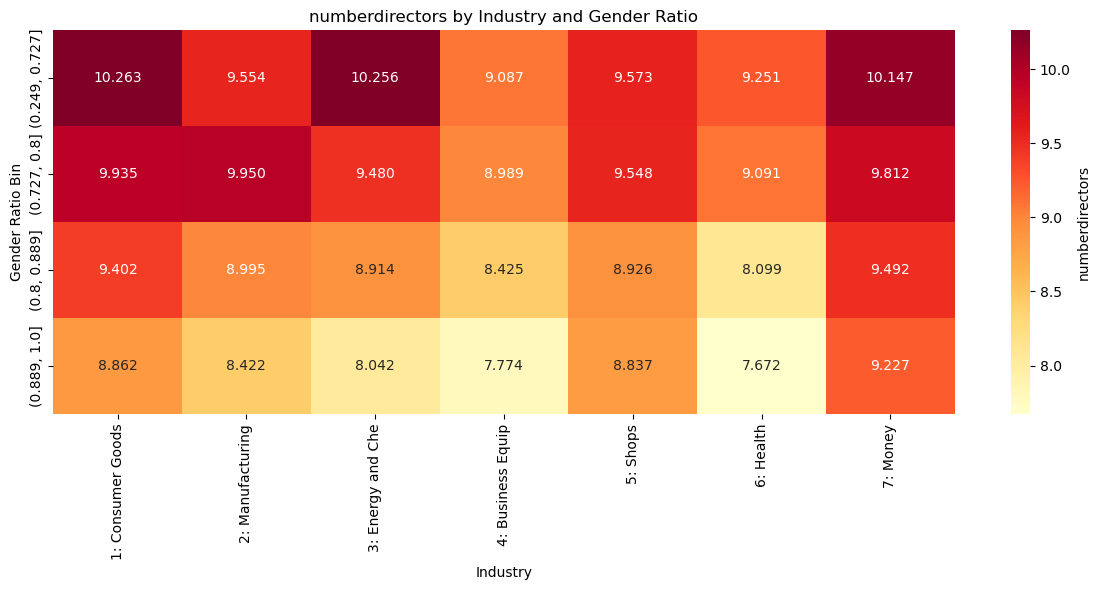

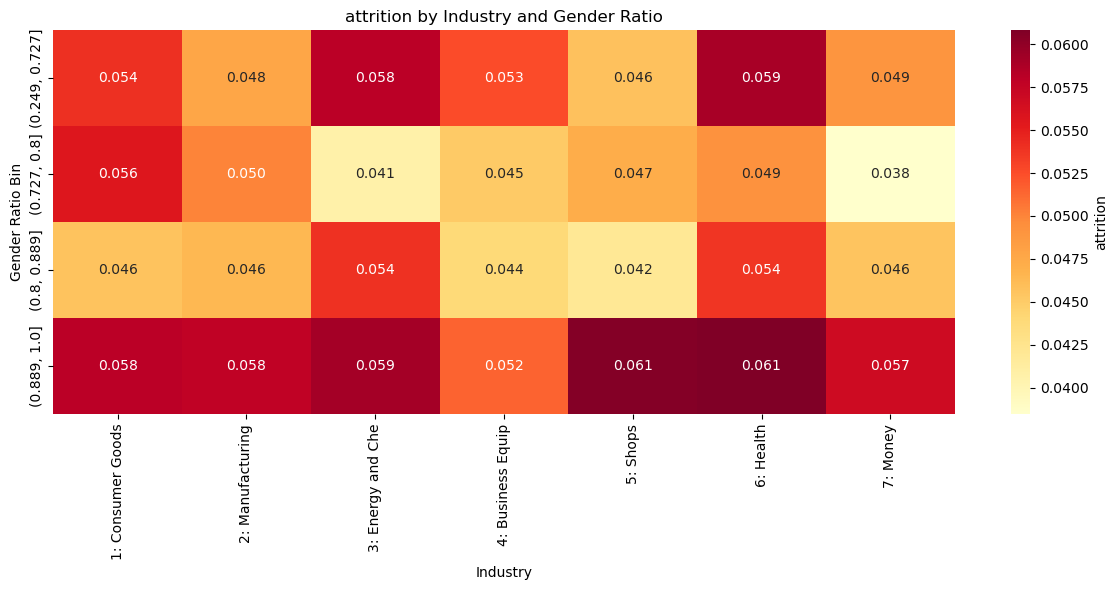

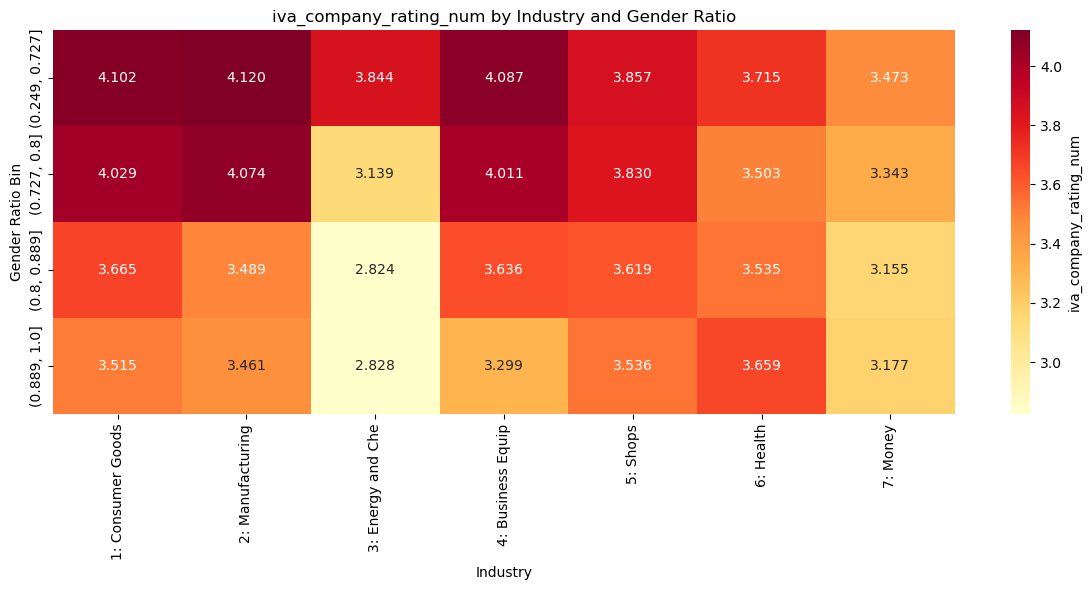

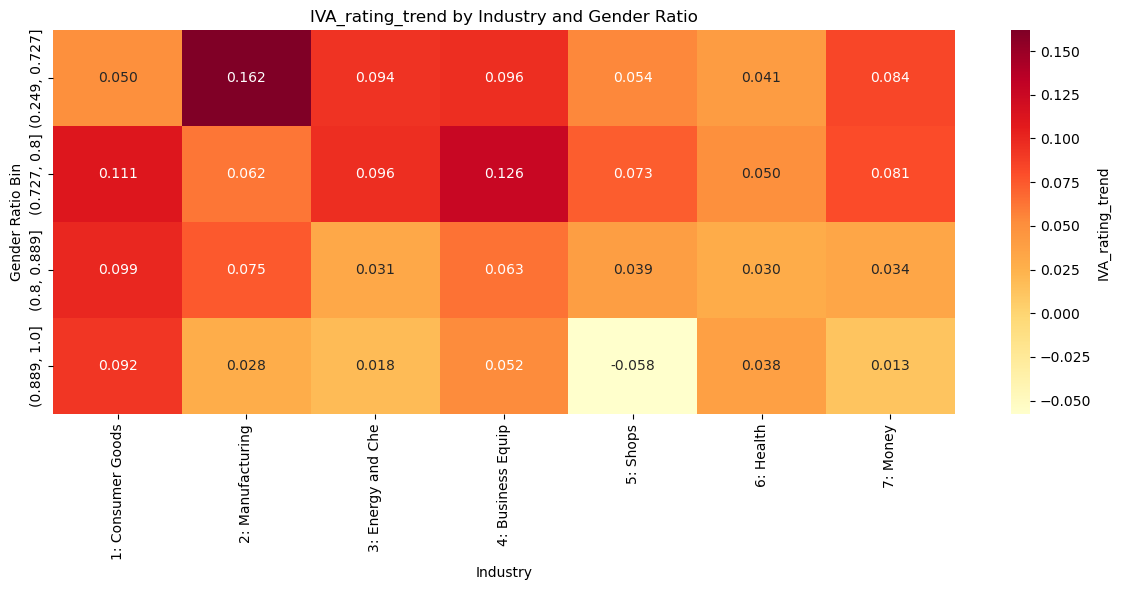

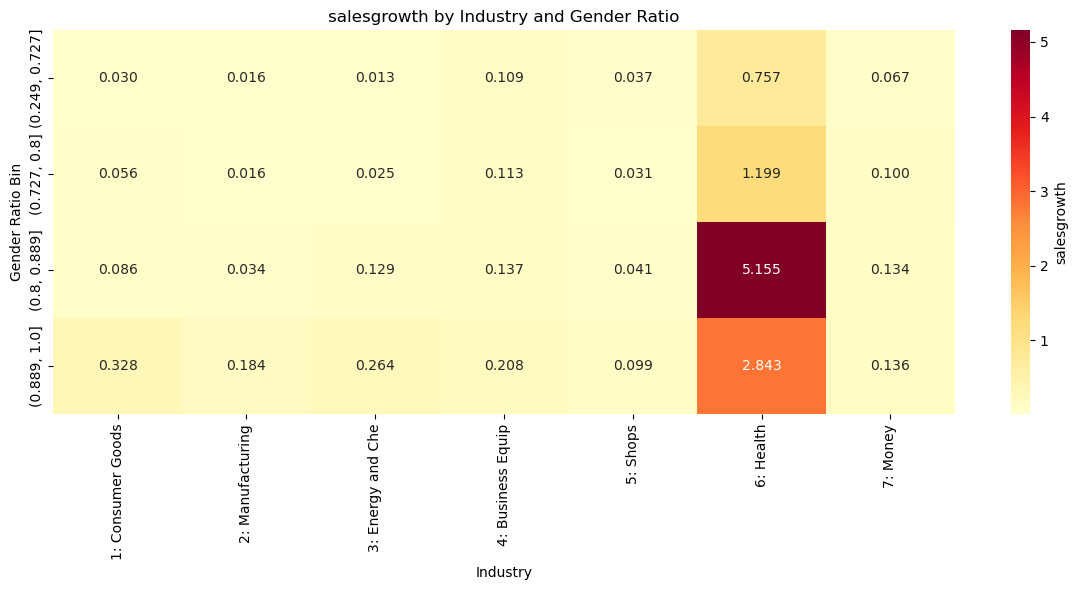

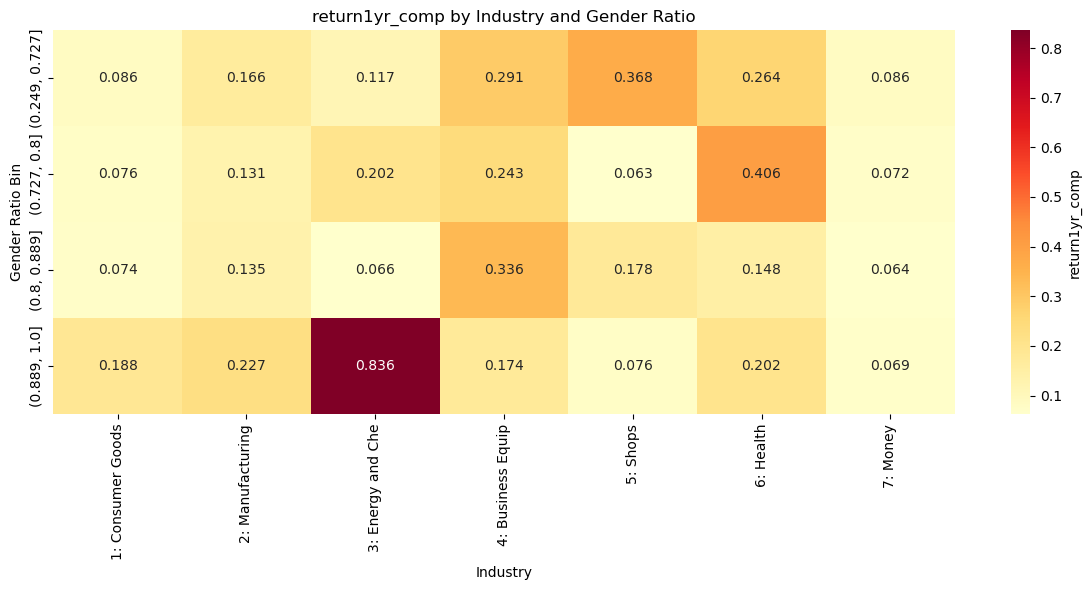

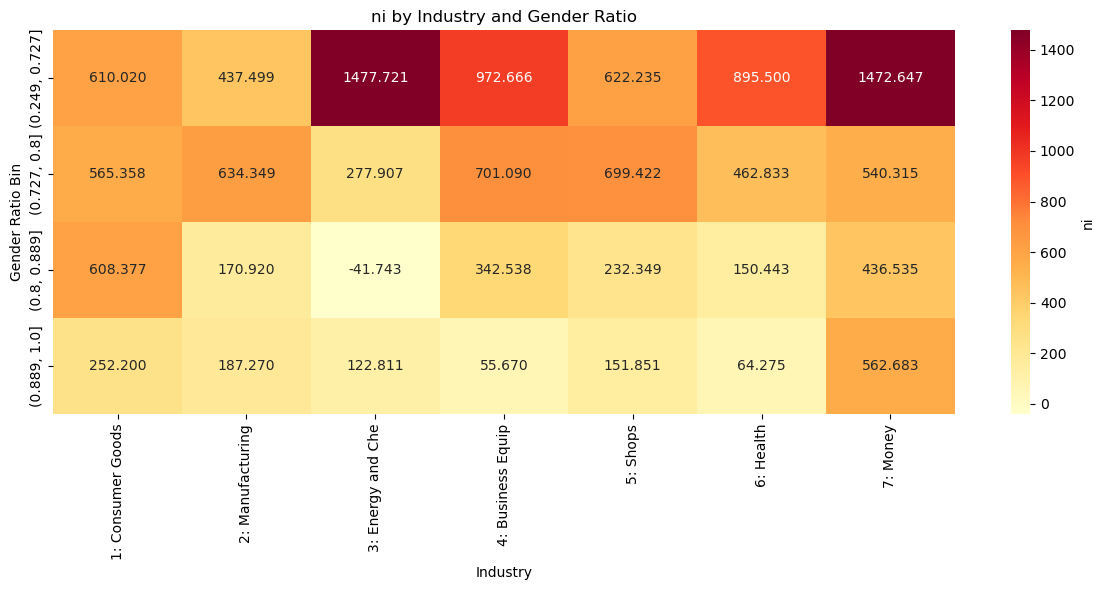

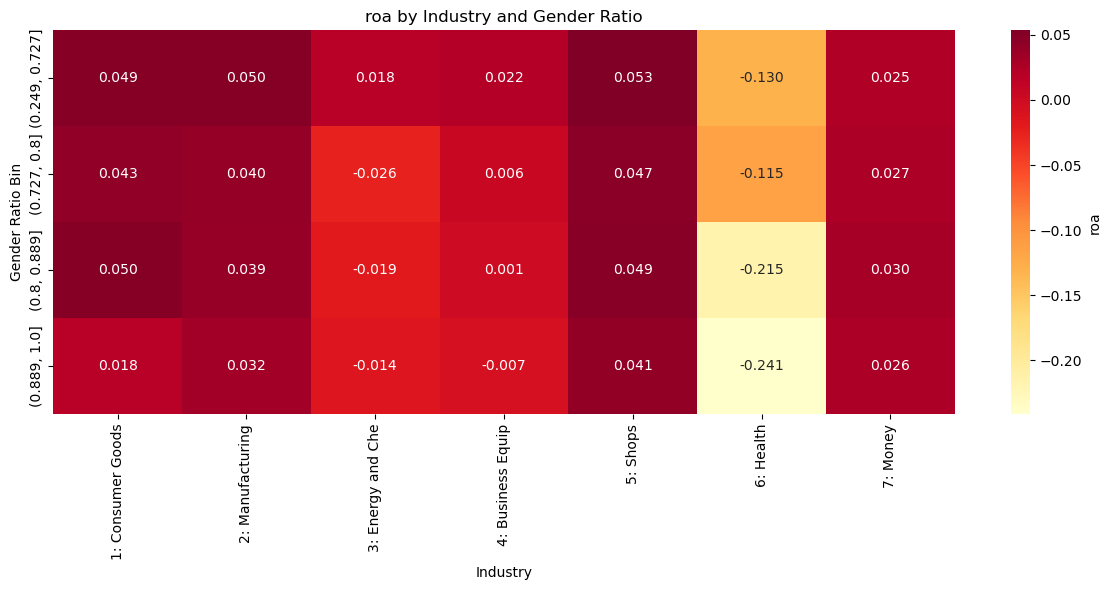

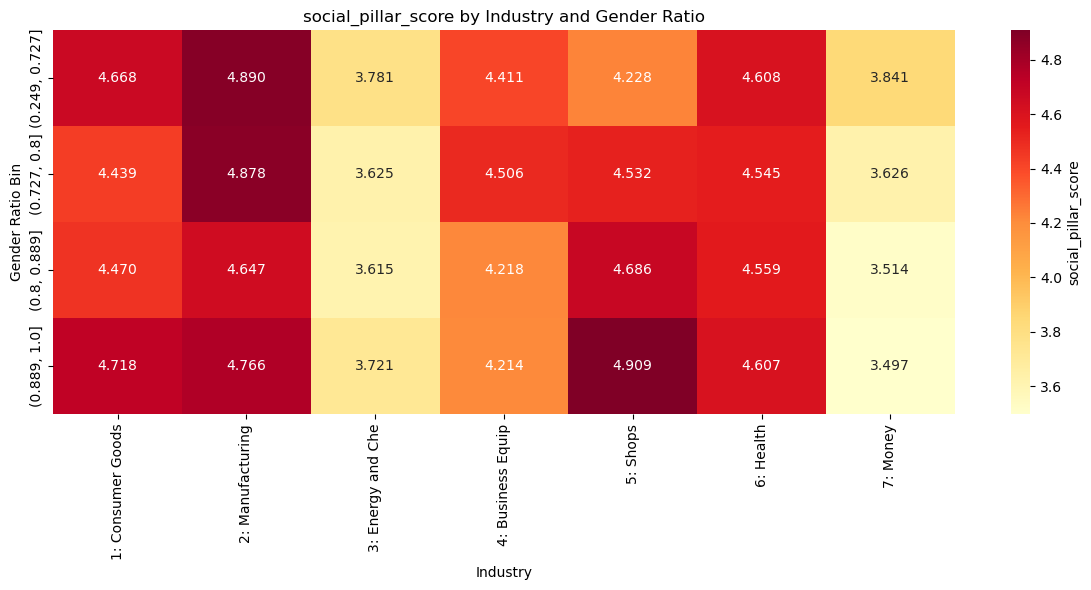

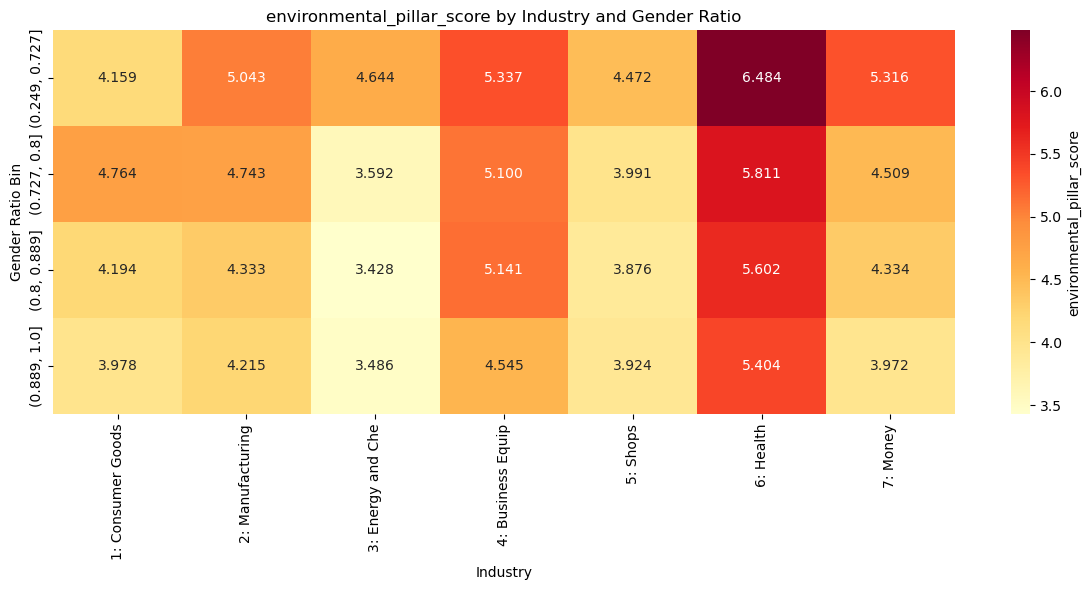

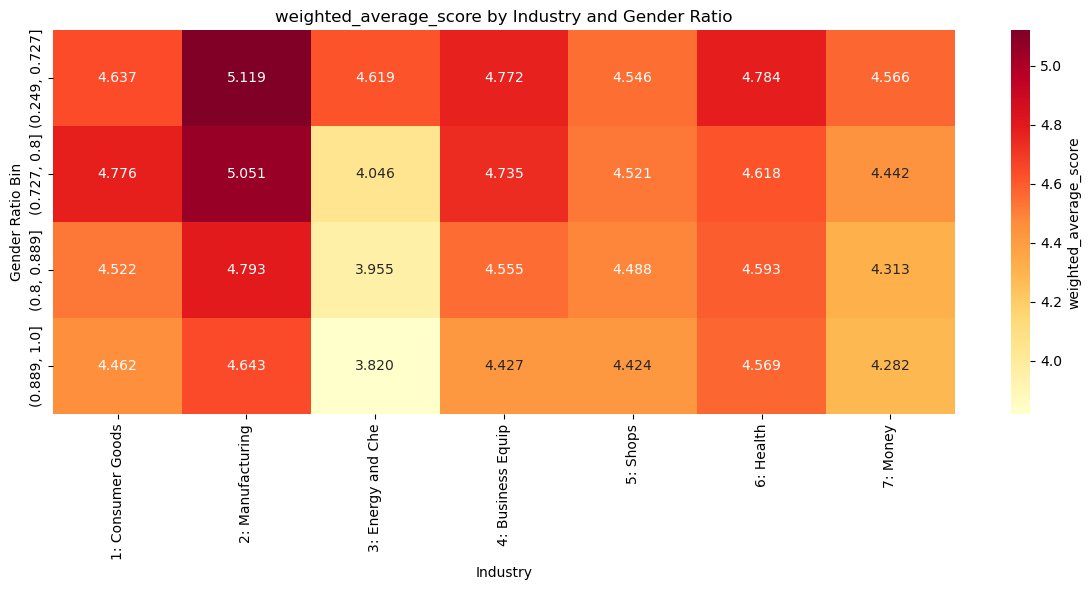

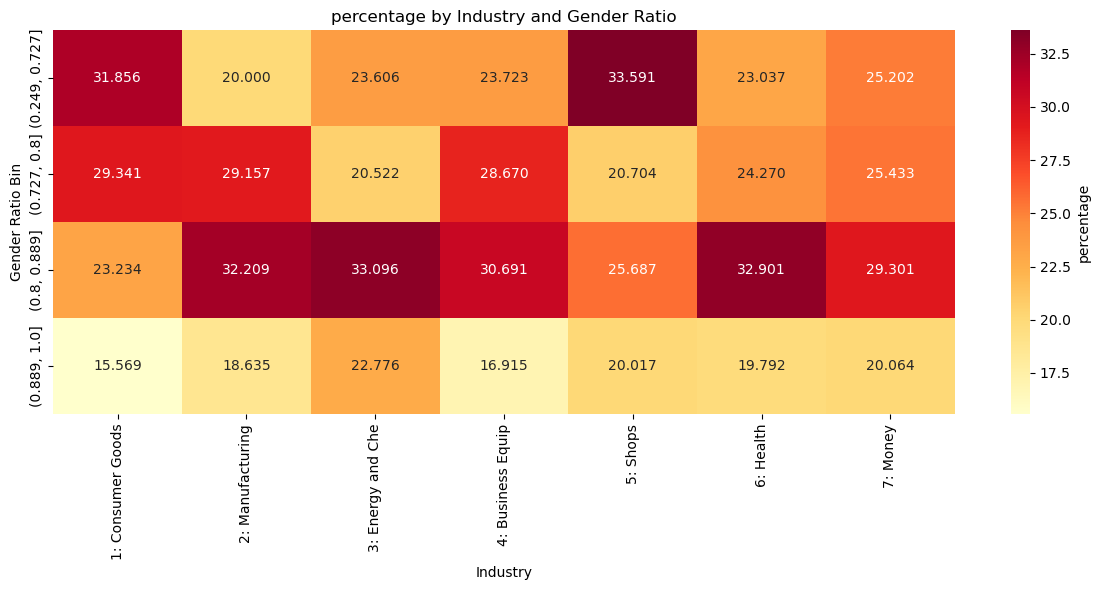

In [15]:
for metric in group_by_sector_and_genderratio.columns:
    heatmap_data = group_by_sector_and_genderratio[metric].unstack(level=0)
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': metric})
    plt.title(f'{metric} by Industry and Gender Ratio')
    plt.xlabel('Industry')
    plt.ylabel('Gender Ratio Bin')
    plt.tight_layout()
    plt.show()

# Machine Learning 

**Task:** Multi-class classification to predict net income performance quartiles

- Converting continuous net income to quartiles makes the problem more interpretable (identifying high/low performers)
- More robust to outliers in financial data

**Class Labels:**
- 0: Bottom 25% (lowest performers)
- 1: 25th-50th percentile
- 2: 50th-75th percentile
- 3: Top 25% (highest performers)

In [110]:
df_ml = X.copy()
df_ml['ni_percentile'] = pd.qcut(df_ml['ni'],q=4, labels=[0,1,2,3])

# Convert desired Categorical features
df_ml['rh_label'] = df_ml['rh_label'].astype('str')
df_ml['numberdirectors'] = df_ml['numberdirectors'].astype('str')
df_ml['iva_company_rating_num'] = df_ml['iva_company_rating_num'].astype('str')

chosen_features = ['attrition','iva_company_rating_num','roa' ,'rh_label', 'nationalitymix','numberdirectors','genderratio','ni_percentile'] 

X_ = df_ml[chosen_features].copy()
X_.dropna(inplace=True)
y = X_['ni_percentile'].astype(str).copy()
X_ = X_.drop('ni_percentile', axis=1)

numerical_features = X_.select_dtypes(include= ['int64','float64']).columns.tolist()
categorical_features = X_.select_dtypes(include= ['object']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=42)

## Building the Pipelines

Creating a comprehensive preprocessing pipeline that handles:
1. **Missing values:** Using median imputation for numerical features
2. **Scaling:** StandardScaler for continuous features to ensure all features have equal weight
3. **Categorical encoding:** Preparing categorical features if present

**Benefits of pipelines:**
- Prevents data leakage by applying transformations consistently
- Makes the model reproducible and production-ready

**Model Categories:**
1. **Naive Bayes variants:** Simple probabilistic classifiers (BernoulliNB, MultinomialNB, GaussianNB, ComplementNB)
2. **Linear models:** Logistic Regression
3. **Instance-based:** K-Nearest Neighbors
4. **Tree-based:** Decision Tree, Random Forest, Gradient Boosting
5. **Ensemble methods:** Bagging, AdaBoost
6. **Gradient boosting variants:** LightGBM, CatBoost, XGBoost

**Evaluation Strategy:**
- 5-fold cross-validation for robust performance estimation
- Multiple metrics: accuracy, precision, recall (macro-averaged for balanced class evaluation)
- Test set holdout for final model validation

In [99]:
estimators = [  
    {'clf': [BernoulliNB()]},
    {'clf': [ComplementNB()]},
    {'clf': [MultinomialNB()]},
    {'clf': [GaussianNB()]},
    {'clf': [LogisticRegression(max_iter=1000, random_state=42)]},
    {'clf': [KNeighborsClassifier()]},
    {'clf': [DecisionTreeClassifier(random_state=42)]},
    {'clf': [RandomForestClassifier(n_estimators=100, random_state=42, verbose=0)]},
    {'clf': [BaggingClassifier(n_estimators=100, random_state=42, verbose=0)]},
    {'clf': [GradientBoostingClassifier(n_estimators=100, random_state=42, verbose=0)]},
    {'clf': [LGBMClassifier(random_state=42, verbose=-1)]},
    {'clf': [CatBoostClassifier(random_state=42, verbose=False)]},
]

num_pipeline = Pipeline([ 
    ('fillna', SimpleImputer(strategy="median")),
    ('scale', MinMaxScaler()),
])

cat_pipeline = Pipeline([
    ('input',SimpleImputer(strategy="constant")),
    ('one_hot', OneHotEncoder(handle_unknown='ignore',sparse_output=False)),
    ])

 
data_pipeline = ColumnTransformer(transformers= [
        # (name, transformer,     columns)
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
])

 
final_pipeline = Pipeline([
        ("preparation", data_pipeline), 
        ('clf', None)
])  

 
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

In [100]:
grid_search = GridSearchCV(final_pipeline, param_grid=estimators,cv=5, n_jobs=-1, scoring=scoring, refit='accuracy',)
t0 = time()
grid_search.fit(X_train,y_train)
 
best_parameters = grid_search.best_estimator_.get_params()
print(f"Best model is {grid_search.best_params_}")
mean_accuracy = grid_search.best_score_
print(f"Mean accuracy of best model: {mean_accuracy:.4f}")
results_df = pd.DataFrame(grid_search.cv_results_)
results_df_box = results_df.copy().T

# Show Results of Analysis
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)
print(f"test_acc on heldout test set by best pipeline is: {accuracy_score(y_pred, y_test):.3f}")
untouched_results_df= results_df.copy()
results_df[["mean_test_accuracy","mean_score_time","param_clf", "mean_test_precision_macro","std_test_precision_macro","std_test_accuracy","mean_test_recall_macro","std_test_recall_macro",]].set_index('param_clf')
 

/opt/anaconda3/envs/cscip556/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cscip556/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best model is {'clf': BaggingClassifier(n_estimators=100, random_state=42)}
Mean accuracy of best model: 0.7271
test_acc on heldout test set by best pipeline is: 0.755


,mean_test_accuracy,mean_score_time,mean_test_precision_macro,std_test_precision_macro,std_test_accuracy,mean_test_recall_macro,std_test_recall_macro
param_clf,,,,,,,
BernoulliNB(),0.451969,0.007031,0.430398,0.011360,0.007825,0.437153,0.008213
ComplementNB(),0.441450,0.009386,0.417416,0.011990,0.013816,0.425846,0.010315
MultinomialNB(),0.454483,0.006823,0.433327,0.012226,0.008620,0.437799,0.007961
GaussianNB(),0.283856,0.006094,0.333434,0.041579,0.011950,0.270382,0.003025
"LogisticRegression(max_iter=1000, random_state=42)",0.507321,0.006409,0.481356,0.018812,0.014707,0.489490,0.012974
KNeighborsClassifier(),0.477129,0.031842,0.471648,0.008550,0.009204,0.470752,0.007495
DecisionTreeClassifier(random_state=42),0.688940,0.006802,0.679414,0.021491,0.022279,0.678914,0.020150
RandomForestClassifier(random_state=42),0.707463,0.019810,0.696188,0.008736,0.012581,0.697205,0.009129
"BaggingClassifier(n_estimators=100, random_state=42)",0.727133,0.018841,0.716791,0.010265,0.012993,0.717351,0.009438


### Performance Analysis

**Key Findings:**
1. **Best Model:** BaggingClassifier achieved 72.7% cross-validation accuracy and 75.5% test accuracy
2. **Ensemble superiority:** Ensemble methods (Bagging, Random Forest, LightGBM) outperformed simpler models
3. **Naive Bayes underperformance:** Simple probabilistic models struggled (44-45% accuracy), suggesting non-linear relationships
4. **Generalization:** Test accuracy exceeds CV accuracy, indicating good generalization without overfitting

**Insights:**
- The ~75% accuracy suggests governance and ESG metrics do contain signal for predicting performance
- The task is challenging - perfect prediction isn't expected given market complexity
- Feature interactions likely important (ensemble methods excel at capturing these)

In [101]:
 print(f"\nTest accuracy with best pipeline is: {accuracy_score(y_pred, y_test):.3f}")
print(f"Test recall (macro): {recall_score(y_test, y_pred, average='macro', zero_division=0):.3f}")
print(f"Test precision (macro): {precision_score(y_test, y_pred, average='macro', zero_division=0):.3f}")
print(f"Test F1-score (macro): {f1_score(y_test, y_pred, average='macro', zero_division=0):.3f}")


Test accuracy with best pipeline is: 0.755
Test recall (macro): 0.751
Test precision (macro): 0.752
Test F1-score (macro): 0.751


## 4. Feature Importance Analysis
Using Random Forest feature importance 

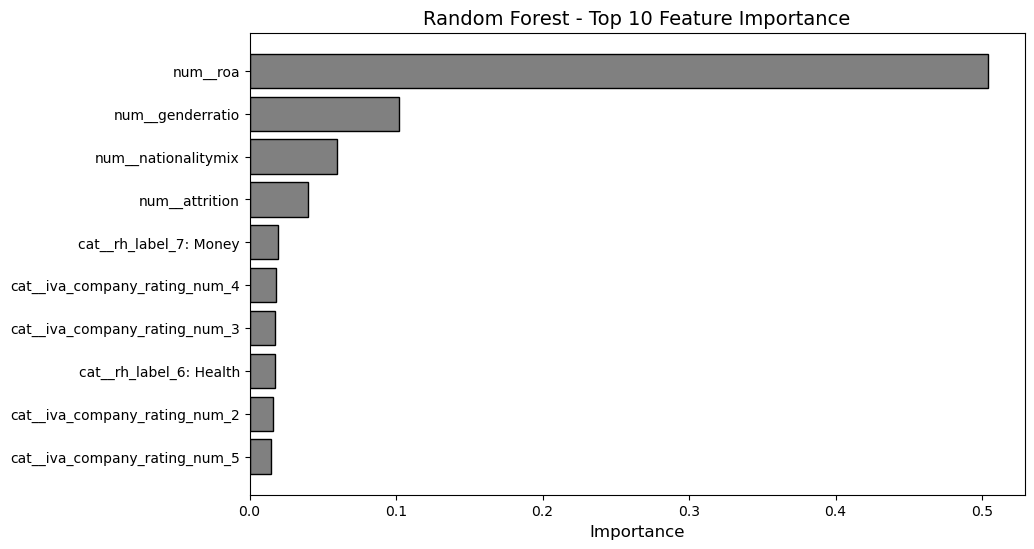

In [104]:
rf_pipeline = Pipeline([
    ("preparation", data_pipeline),
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42, verbose=0))
])
rf_pipeline.fit(X_train, y_train)
feature_names = rf_pipeline.named_steps['preparation'].get_feature_names_out()
importances = rf_pipeline.named_steps['clf'].feature_importances_
rf_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
top_rf = rf_importance.head(10)

plt.figure(figsize=(10,6))
plt.barh(range(len(top_rf)), top_rf['importance'],color='grey', edgecolor='black')
plt.yticks(range(len(top_rf)), top_rf['feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Random Forest - Top 10 Feature Importance', fontsize=14)
plt.gca().invert_yaxis()
plt.show()

### Feature Importance Insights
- The most important features reveal which governance and ESG metrics best predict financial performance
- Financial metrics (ROA) likely dominate as they directly relate to profitability
- Genderratio plays importance in profitability.

**Business Implications:**
- Companies can focus improvement efforts on high-importance governance factors

## 5. Hyperparameter Optimization

### Advanced Model Tuning with Optuna

Using Bayesian optimization (via Optuna) to fine-tune the best performing model. This is more efficient than grid search:

## Hyperparameter Tuning

In [119]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 80, 300),
        'max_samples': trial.suggest_float('max_samples', 0.5, 1.0),
        'max_features': trial.suggest_float('max_features', 0.5, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'bootstrap_features': trial.suggest_categorical('bootstrap_features', [True, False]),
        'random_state': 42
    }
 
    model = Pipeline([
        ("preparation", data_pipeline), 
        ('clf', BaggingClassifier(**params))
    ])  
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70,show_progress_bar=True)

print("Best parameters:", study.best_params)
print("Best score:", study.best_value)
model = Pipeline([
        ("preparation", data_pipeline), 
        ('clf', BaggingClassifier(**study.best_params, random_state=42))
    ])
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")

[I 2026-01-06 13:15:58,605] A new study created in memory with name: no-name-e799d0f9-cdcc-4b95-a18e-d391f048f430
Best trial: 0. Best value: 0.726673:   1%|▉                                                                | 1/70 [00:02<02:25,  2.11s/it]

[I 2026-01-06 13:16:00,714] Trial 0 finished with value: 0.7266732919254658 and parameters: {'n_estimators': 116, 'max_samples': 0.6387522697700182, 'max_features': 0.7714283430737392, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 0 with value: 0.7266732919254658.


Best trial: 0. Best value: 0.726673:   3%|█▊                                                               | 2/70 [00:12<08:09,  7.20s/it]

[I 2026-01-06 13:16:11,470] Trial 1 finished with value: 0.7063194508009153 and parameters: {'n_estimators': 258, 'max_samples': 0.9921084523631802, 'max_features': 0.9625070420998714, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 0 with value: 0.7266732919254658.


Best trial: 0. Best value: 0.726673:   4%|██▊                                                              | 3/70 [00:15<05:30,  4.94s/it]

[I 2026-01-06 13:16:13,720] Trial 2 finished with value: 0.7248452435436417 and parameters: {'n_estimators': 107, 'max_samples': 0.5301994543830074, 'max_features': 0.7491406698609357, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 0 with value: 0.7266732919254658.


Best trial: 3. Best value: 0.730562:   6%|███▋                                                             | 4/70 [00:18<04:56,  4.49s/it]

[I 2026-01-06 13:16:17,537] Trial 3 finished with value: 0.7305624060150376 and parameters: {'n_estimators': 175, 'max_samples': 0.8001813431216562, 'max_features': 0.775511208093069, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 3 with value: 0.7305624060150376.


Best trial: 3. Best value: 0.730562:   7%|████▋                                                            | 5/70 [00:22<04:41,  4.33s/it]

[I 2026-01-06 13:16:21,580] Trial 4 finished with value: 0.7200434128800262 and parameters: {'n_estimators': 223, 'max_samples': 0.7666334406040011, 'max_features': 0.5608396792100121, 'bootstrap': False, 'bootstrap_features': True}. Best is trial 3 with value: 0.7305624060150376.


Best trial: 3. Best value: 0.730562:   9%|█████▌                                                           | 6/70 [00:27<04:34,  4.30s/it]

[I 2026-01-06 13:16:25,808] Trial 5 finished with value: 0.7298764302059497 and parameters: {'n_estimators': 197, 'max_samples': 0.7271654550095124, 'max_features': 0.6253977376906319, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 3 with value: 0.7305624060150376.


Best trial: 3. Best value: 0.730562:  10%|██████▌                                                          | 7/70 [00:28<03:33,  3.40s/it]

[I 2026-01-06 13:16:27,350] Trial 6 finished with value: 0.6864203988231449 and parameters: {'n_estimators': 90, 'max_samples': 0.9064891545535615, 'max_features': 0.5293149538618036, 'bootstrap': False, 'bootstrap_features': True}. Best is trial 3 with value: 0.7305624060150376.


Best trial: 3. Best value: 0.730562:  11%|███████▍                                                         | 8/70 [00:30<03:00,  2.91s/it]

[I 2026-01-06 13:16:29,231] Trial 7 finished with value: 0.7269031709709055 and parameters: {'n_estimators': 88, 'max_samples': 0.6477113496905216, 'max_features': 0.9485484876432874, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 3 with value: 0.7305624060150376.


Best trial: 3. Best value: 0.730562:  13%|████████▎                                                        | 9/70 [00:33<02:50,  2.79s/it]

[I 2026-01-06 13:16:31,744] Trial 8 finished with value: 0.714095325269696 and parameters: {'n_estimators': 112, 'max_samples': 0.7140090955485281, 'max_features': 0.8045537023797918, 'bootstrap': False, 'bootstrap_features': True}. Best is trial 3 with value: 0.7305624060150376.


Best trial: 3. Best value: 0.730562:  14%|█████████▏                                                      | 10/70 [00:36<02:59,  3.00s/it]

[I 2026-01-06 13:16:35,202] Trial 9 finished with value: 0.7218711997384766 and parameters: {'n_estimators': 236, 'max_samples': 0.7778775029581163, 'max_features': 0.618669784415887, 'bootstrap': True, 'bootstrap_features': True}. Best is trial 3 with value: 0.7305624060150376.


Best trial: 10. Best value: 0.730791:  16%|█████████▉                                                     | 11/70 [00:43<04:08,  4.21s/it]

[I 2026-01-06 13:16:42,167] Trial 10 finished with value: 0.7307912389669827 and parameters: {'n_estimators': 299, 'max_samples': 0.8716886876582992, 'max_features': 0.8620200329811812, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 10 with value: 0.7307912389669827.


Best trial: 10. Best value: 0.730791:  17%|██████████▊                                                    | 12/70 [00:50<04:52,  5.03s/it]

[I 2026-01-06 13:16:49,088] Trial 11 finished with value: 0.7298753841124551 and parameters: {'n_estimators': 289, 'max_samples': 0.8554619082584508, 'max_features': 0.8618052096741082, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 10 with value: 0.7307912389669827.


Best trial: 12. Best value: 0.730792:  19%|███████████▋                                                   | 13/70 [00:54<04:25,  4.66s/it]

[I 2026-01-06 13:16:52,879] Trial 12 finished with value: 0.7307915004903565 and parameters: {'n_estimators': 154, 'max_samples': 0.880649143389048, 'max_features': 0.8664205289863465, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 12 with value: 0.7307915004903565.


Best trial: 13. Best value: 0.735138:  20%|████████████▌                                                  | 14/70 [00:58<04:10,  4.47s/it]

[I 2026-01-06 13:16:56,917] Trial 13 finished with value: 0.7351380189604446 and parameters: {'n_estimators': 156, 'max_samples': 0.9331064023844807, 'max_features': 0.8864805675553885, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  21%|█████████████▌                                                 | 15/70 [01:02<04:03,  4.42s/it]

[I 2026-01-06 13:17:01,222] Trial 14 finished with value: 0.7305647597254005 and parameters: {'n_estimators': 156, 'max_samples': 0.9927927272381558, 'max_features': 0.8822130582738656, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  23%|██████████████▍                                                | 16/70 [01:06<03:55,  4.35s/it]

[I 2026-01-06 13:17:05,420] Trial 15 finished with value: 0.7326229486760379 and parameters: {'n_estimators': 147, 'max_samples': 0.9392539702224469, 'max_features': 0.994630512802701, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  24%|███████████████▎                                               | 17/70 [01:10<03:42,  4.20s/it]

[I 2026-01-06 13:17:09,256] Trial 16 finished with value: 0.7312491663942465 and parameters: {'n_estimators': 142, 'max_samples': 0.9495230961890284, 'max_features': 0.9615054093890065, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  26%|████████████████▏                                              | 18/70 [01:15<03:53,  4.50s/it]

[I 2026-01-06 13:17:14,447] Trial 17 finished with value: 0.7349089244851259 and parameters: {'n_estimators': 192, 'max_samples': 0.932100415532165, 'max_features': 0.996627610335633, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  27%|█████████████████                                              | 19/70 [01:19<03:31,  4.14s/it]

[I 2026-01-06 13:17:17,768] Trial 18 finished with value: 0.7243881006864988 and parameters: {'n_estimators': 194, 'max_samples': 0.8345753877050022, 'max_features': 0.7020813802520339, 'bootstrap': True, 'bootstrap_features': True}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  29%|██████████████████                                             | 20/70 [01:24<03:46,  4.53s/it]

[I 2026-01-06 13:17:23,193] Trial 19 finished with value: 0.73079176201373 and parameters: {'n_estimators': 213, 'max_samples': 0.9377635890542593, 'max_features': 0.9153438334980674, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  30%|██████████████████▉                                            | 21/70 [01:29<03:40,  4.50s/it]

[I 2026-01-06 13:17:27,642] Trial 20 finished with value: 0.7280478587773782 and parameters: {'n_estimators': 175, 'max_samples': 0.8260446534786481, 'max_features': 0.9979784111488323, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  31%|███████████████████▊                                           | 22/70 [01:32<03:22,  4.23s/it]

[I 2026-01-06 13:17:31,226] Trial 21 finished with value: 0.7323938542007193 and parameters: {'n_estimators': 131, 'max_samples': 0.9299756354427285, 'max_features': 0.9964953668209227, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  33%|████████████████████▋                                          | 23/70 [01:37<03:21,  4.29s/it]

[I 2026-01-06 13:17:35,657] Trial 22 finished with value: 0.7326229486760379 and parameters: {'n_estimators': 170, 'max_samples': 0.9580371025504288, 'max_features': 0.9198483050018229, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  34%|█████████████████████▌                                         | 24/70 [01:40<03:06,  4.05s/it]

[I 2026-01-06 13:17:39,141] Trial 23 finished with value: 0.7285060477280159 and parameters: {'n_estimators': 140, 'max_samples': 0.8896747561637975, 'max_features': 0.9205964786175838, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  36%|██████████████████████▌                                        | 25/70 [01:45<03:15,  4.35s/it]

[I 2026-01-06 13:17:44,187] Trial 24 finished with value: 0.7303340961098398 and parameters: {'n_estimators': 208, 'max_samples': 0.9957350725182654, 'max_features': 0.8268594344251922, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  37%|███████████████████████▍                                       | 26/70 [01:49<03:11,  4.36s/it]

[I 2026-01-06 13:17:48,570] Trial 25 finished with value: 0.7275883622098724 and parameters: {'n_estimators': 164, 'max_samples': 0.9058607883574908, 'max_features': 0.9906584848465954, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  39%|████████████████████████▎                                      | 27/70 [01:54<03:07,  4.36s/it]

[I 2026-01-06 13:17:52,941] Trial 26 finished with value: 0.7223275580254985 and parameters: {'n_estimators': 186, 'max_samples': 0.9515072694229538, 'max_features': 0.9077308677307332, 'bootstrap': True, 'bootstrap_features': True}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  40%|█████████████████████████▏                                     | 28/70 [01:57<02:47,  3.99s/it]

[I 2026-01-06 13:17:56,059] Trial 27 finished with value: 0.7287301732592351 and parameters: {'n_estimators': 128, 'max_samples': 0.8143092435905919, 'max_features': 0.9486106596132245, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  41%|██████████████████████████                                     | 29/70 [02:01<02:44,  4.02s/it]

[I 2026-01-06 13:18:00,142] Trial 28 finished with value: 0.7253010787839163 and parameters: {'n_estimators': 252, 'max_samples': 0.506721808388333, 'max_features': 0.8328732755076151, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  43%|███████████████████████████                                    | 30/70 [02:04<02:29,  3.75s/it]

[I 2026-01-06 13:18:03,265] Trial 29 finished with value: 0.7307909774436091 and parameters: {'n_estimators': 183, 'max_samples': 0.6733997220938882, 'max_features': 0.6968046728635438, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  44%|███████████████████████████▉                                   | 31/70 [02:07<02:17,  3.52s/it]

[I 2026-01-06 13:18:06,253] Trial 30 finished with value: 0.7321626675384112 and parameters: {'n_estimators': 149, 'max_samples': 0.5921382119240916, 'max_features': 0.9699776443883247, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  46%|████████████████████████████▊                                  | 32/70 [02:11<02:23,  3.77s/it]

[I 2026-01-06 13:18:10,598] Trial 31 finished with value: 0.730106570774763 and parameters: {'n_estimators': 168, 'max_samples': 0.9562953877299007, 'max_features': 0.9126060603763734, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  47%|█████████████████████████████▋                                 | 33/70 [02:15<02:15,  3.66s/it]

[I 2026-01-06 13:18:14,001] Trial 32 finished with value: 0.7298790454396862 and parameters: {'n_estimators': 126, 'max_samples': 0.9717474121800037, 'max_features': 0.9302235462601477, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  49%|██████████████████████████████▌                                | 34/70 [02:20<02:27,  4.09s/it]

[I 2026-01-06 13:18:19,115] Trial 33 finished with value: 0.7330774762994443 and parameters: {'n_estimators': 206, 'max_samples': 0.9194031825300372, 'max_features': 0.8895608243927232, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  50%|███████████████████████████████▌                               | 35/70 [02:27<02:58,  5.09s/it]

[I 2026-01-06 13:18:26,534] Trial 34 finished with value: 0.728045766590389 and parameters: {'n_estimators': 236, 'max_samples': 0.9179467114743738, 'max_features': 0.7498542618153798, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  51%|████████████████████████████████▍                              | 36/70 [02:33<02:53,  5.10s/it]

[I 2026-01-06 13:18:31,639] Trial 35 finished with value: 0.7301057862046421 and parameters: {'n_estimators': 202, 'max_samples': 0.8581306819717279, 'max_features': 0.9727163115166947, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  53%|█████████████████████████████████▎                             | 37/70 [02:40<03:16,  5.96s/it]

[I 2026-01-06 13:18:39,601] Trial 36 finished with value: 0.72141379535796 and parameters: {'n_estimators': 221, 'max_samples': 0.8984509402744931, 'max_features': 0.8899221319719346, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  54%|██████████████████████████████████▏                            | 38/70 [02:42<02:31,  4.74s/it]

[I 2026-01-06 13:18:41,517] Trial 37 finished with value: 0.7090638770840144 and parameters: {'n_estimators': 100, 'max_samples': 0.979417600214313, 'max_features': 0.7787302529342225, 'bootstrap': True, 'bootstrap_features': True}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  56%|███████████████████████████████████                            | 39/70 [02:48<02:35,  5.01s/it]

[I 2026-01-06 13:18:47,136] Trial 38 finished with value: 0.7307896698267408 and parameters: {'n_estimators': 188, 'max_samples': 0.7876872257608891, 'max_features': 0.8297468288059517, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  57%|████████████████████████████████████                           | 40/70 [02:52<02:24,  4.80s/it]

[I 2026-01-06 13:18:51,462] Trial 39 finished with value: 0.7307896698267408 and parameters: {'n_estimators': 234, 'max_samples': 0.7521864670380123, 'max_features': 0.7204012441261352, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  59%|████████████████████████████████████▉                          | 41/70 [03:02<03:02,  6.30s/it]

[I 2026-01-06 13:19:01,272] Trial 40 finished with value: 0.7246203334423015 and parameters: {'n_estimators': 274, 'max_samples': 0.9249865328448039, 'max_features': 0.9519648922658093, 'bootstrap': False, 'bootstrap_features': True}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  60%|█████████████████████████████████████▊                         | 42/70 [03:07<02:42,  5.82s/it]

[I 2026-01-06 13:19:05,955] Trial 41 finished with value: 0.7319359267734554 and parameters: {'n_estimators': 176, 'max_samples': 0.9674082533449669, 'max_features': 0.9413268345173627, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  61%|██████████████████████████████████████▋                        | 43/70 [03:11<02:24,  5.37s/it]

[I 2026-01-06 13:19:10,274] Trial 42 finished with value: 0.7344507355344884 and parameters: {'n_estimators': 173, 'max_samples': 0.931684731117428, 'max_features': 0.8944203158983645, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  63%|███████████████████████████████████████▌                       | 44/70 [03:15<02:05,  4.81s/it]

[I 2026-01-06 13:19:13,790] Trial 43 finished with value: 0.7317065707747631 and parameters: {'n_estimators': 161, 'max_samples': 0.8502364649004556, 'max_features': 0.798153516627379, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  64%|████████████████████████████████████████▌                      | 45/70 [03:20<02:00,  4.82s/it]

[I 2026-01-06 13:19:18,634] Trial 44 finished with value: 0.7291922850604774 and parameters: {'n_estimators': 200, 'max_samples': 0.8862806055918484, 'max_features': 0.8870766308126938, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  66%|█████████████████████████████████████████▍                     | 46/70 [03:23<01:45,  4.39s/it]

[I 2026-01-06 13:19:22,029] Trial 45 finished with value: 0.7319346191565872 and parameters: {'n_estimators': 143, 'max_samples': 0.9160233320046653, 'max_features': 0.8515503998889092, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  67%|██████████████████████████████████████████▎                    | 47/70 [03:28<01:42,  4.45s/it]

[I 2026-01-06 13:19:26,613] Trial 46 finished with value: 0.7296489048708727 and parameters: {'n_estimators': 180, 'max_samples': 0.8693385732627791, 'max_features': 0.973383814192591, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  69%|███████████████████████████████████████████▏                   | 48/70 [03:32<01:35,  4.34s/it]

[I 2026-01-06 13:19:30,682] Trial 47 finished with value: 0.728961359921543 and parameters: {'n_estimators': 217, 'max_samples': 0.9983556841258565, 'max_features': 0.626585985171989, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  70%|████████████████████████████████████████████                   | 49/70 [03:35<01:25,  4.06s/it]

[I 2026-01-06 13:19:34,088] Trial 48 finished with value: 0.7179839163125205 and parameters: {'n_estimators': 153, 'max_samples': 0.9332740224457013, 'max_features': 0.894903782459202, 'bootstrap': True, 'bootstrap_features': True}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  71%|█████████████████████████████████████████████                  | 50/70 [03:38<01:12,  3.61s/it]

[I 2026-01-06 13:19:36,664] Trial 49 finished with value: 0.7278195488721805 and parameters: {'n_estimators': 114, 'max_samples': 0.5893754079315241, 'max_features': 0.8071202446027577, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  73%|█████████████████████████████████████████████▉                 | 51/70 [03:42<01:11,  3.75s/it]

[I 2026-01-06 13:19:40,732] Trial 50 finished with value: 0.7273592677345537 and parameters: {'n_estimators': 194, 'max_samples': 0.7154914758984608, 'max_features': 0.8688895892311126, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  74%|██████████████████████████████████████████████▊                | 52/70 [03:46<01:10,  3.94s/it]

[I 2026-01-06 13:19:45,127] Trial 51 finished with value: 0.7305644982020268 and parameters: {'n_estimators': 167, 'max_samples': 0.9483242317928905, 'max_features': 0.9360510252923483, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  76%|███████████████████████████████████████████████▋               | 53/70 [03:50<01:09,  4.10s/it]

[I 2026-01-06 13:19:49,587] Trial 52 finished with value: 0.7305631905851586 and parameters: {'n_estimators': 171, 'max_samples': 0.9736671577701541, 'max_features': 0.905645568947295, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  77%|████████████████████████████████████████████████▌              | 54/70 [03:56<01:11,  4.49s/it]

[I 2026-01-06 13:19:55,003] Trial 53 finished with value: 0.7271327884929717 and parameters: {'n_estimators': 204, 'max_samples': 0.8997793783054765, 'max_features': 0.984858619177353, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  79%|█████████████████████████████████████████████████▌             | 55/70 [04:00<01:04,  4.31s/it]

[I 2026-01-06 13:19:58,876] Trial 54 finished with value: 0.7307899313501144 and parameters: {'n_estimators': 158, 'max_samples': 0.9395696245962604, 'max_features': 0.8770904366406878, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  80%|██████████████████████████████████████████████████▍            | 56/70 [04:03<00:56,  4.01s/it]

[I 2026-01-06 13:20:02,202] Trial 55 finished with value: 0.7310185027786859 and parameters: {'n_estimators': 135, 'max_samples': 0.9643250351787453, 'max_features': 0.8547776538799222, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  81%|███████████████████████████████████████████████████▎           | 57/70 [04:05<00:45,  3.51s/it]

[I 2026-01-06 13:20:04,549] Trial 56 finished with value: 0.719586531546257 and parameters: {'n_estimators': 150, 'max_samples': 0.9142030332452644, 'max_features': 0.5062528364834459, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  83%|████████████████████████████████████████████████████▏          | 58/70 [04:11<00:50,  4.24s/it]

[I 2026-01-06 13:20:10,489] Trial 57 finished with value: 0.7314772147760706 and parameters: {'n_estimators': 226, 'max_samples': 0.9863506810966999, 'max_features': 0.9283956697024782, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  84%|█████████████████████████████████████████████████████          | 59/70 [04:16<00:47,  4.29s/it]

[I 2026-01-06 13:20:14,904] Trial 58 finished with value: 0.7259878391631253 and parameters: {'n_estimators': 191, 'max_samples': 0.838966434992131, 'max_features': 0.9544879542987789, 'bootstrap': True, 'bootstrap_features': True}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  86%|██████████████████████████████████████████████████████         | 60/70 [04:21<00:44,  4.45s/it]

[I 2026-01-06 13:20:19,733] Trial 59 finished with value: 0.7294187643020594 and parameters: {'n_estimators': 210, 'max_samples': 0.8728418871895498, 'max_features': 0.8467067121825946, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  87%|██████████████████████████████████████████████████████▉        | 61/70 [04:24<00:37,  4.15s/it]

[I 2026-01-06 13:20:23,187] Trial 60 finished with value: 0.7317068322981367 and parameters: {'n_estimators': 124, 'max_samples': 0.9397887746205162, 'max_features': 0.9993585481258369, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  89%|███████████████████████████████████████████████████████▊       | 62/70 [04:28<00:32,  4.02s/it]

[I 2026-01-06 13:20:26,882] Trial 61 finished with value: 0.7344523046747303 and parameters: {'n_estimators': 135, 'max_samples': 0.9345205387113293, 'max_features': 0.9838793136380781, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  90%|████████████████████████████████████████████████████████▋      | 63/70 [04:32<00:28,  4.02s/it]

[I 2026-01-06 13:20:30,918] Trial 62 finished with value: 0.7326216410591698 and parameters: {'n_estimators': 144, 'max_samples': 0.9535896514126465, 'max_features': 0.9809547773261924, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  91%|█████████████████████████████████████████████████████████▌     | 64/70 [04:36<00:25,  4.22s/it]

[I 2026-01-06 13:20:35,603] Trial 63 finished with value: 0.7280447204968945 and parameters: {'n_estimators': 175, 'max_samples': 0.8880513826448261, 'max_features': 0.9601022252156995, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  93%|██████████████████████████████████████████████████████████▌    | 65/70 [04:39<00:18,  3.78s/it]

[I 2026-01-06 13:20:38,343] Trial 64 finished with value: 0.7310187643020595 and parameters: {'n_estimators': 107, 'max_samples': 0.9237172681715218, 'max_features': 0.9026715922939166, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  94%|███████████████████████████████████████████████████████████▍   | 66/70 [04:42<00:14,  3.60s/it]

[I 2026-01-06 13:20:41,527] Trial 65 finished with value: 0.7259878391631253 and parameters: {'n_estimators': 120, 'max_samples': 0.9062994924623307, 'max_features': 0.9320252750611157, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  96%|████████████████████████████████████████████████████████████▎  | 67/70 [04:46<00:10,  3.62s/it]

[I 2026-01-06 13:20:45,184] Trial 66 finished with value: 0.7294185027786859 and parameters: {'n_estimators': 137, 'max_samples': 0.9812508741215067, 'max_features': 0.9190478023818485, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  97%|█████████████████████████████████████████████████████████████▏ | 68/70 [04:51<00:08,  4.07s/it]

[I 2026-01-06 13:20:50,316] Trial 67 finished with value: 0.7307915004903563 and parameters: {'n_estimators': 181, 'max_samples': 0.958147121013441, 'max_features': 0.9715397534095792, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138:  99%|██████████████████████████████████████████████████████████████ | 69/70 [04:57<00:04,  4.69s/it]

[I 2026-01-06 13:20:56,458] Trial 68 finished with value: 0.7223259888852567 and parameters: {'n_estimators': 162, 'max_samples': 0.8121076063148354, 'max_features': 0.9866902260791766, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 13 with value: 0.7351380189604446.


Best trial: 13. Best value: 0.735138: 100%|███████████████████████████████████████████████████████████████| 70/70 [05:02<00:00,  4.32s/it]


[I 2026-01-06 13:21:00,668] Trial 69 finished with value: 0.7195813010787838 and parameters: {'n_estimators': 170, 'max_samples': 0.9362038553344177, 'max_features': 0.9472491509779838, 'bootstrap': True, 'bootstrap_features': True}. Best is trial 13 with value: 0.7351380189604446.
Best parameters: {'n_estimators': 156, 'max_samples': 0.9331064023844807, 'max_features': 0.8864805675553885, 'bootstrap': True, 'bootstrap_features': False}
Best score: 0.7351380189604446
Test accuracy: 0.7550274223034735


## 6. Conclusions and Key Takeaways

### Project Summary

**Achievements:**
1. Successfully built a classification model predicting company performance quartiles with ~75% accuracy
2. Identified key governance and ESG factors that correlate with financial performance
3. Demonstrated that ensemble methods outperform simpler approaches for this task
4. Created a reproducible ML pipeline suitable for production deployment


**Current Limitations:**
- Limited temporal data (5 years); more historical data could improve predictions
- Limited data size; the dataset only contains 10k instances a very medium-sized dataset; however not large enough for drawing conclusions